<h1>기계학습(8585) 기말고사 대체 과제</h1>

**<div style="text-align: right"> 201920829 금동호 </div>**

**<h4>목표:</h4>**
<div>
본 과제에서는 주어진 물건 구매 후 리뷰에 대한 텍스트 데이터를 감성으로 분류하는 감성 분석 시스템을 개발해본다.
학번이 홀수로 끝나므로, amazon_uk_shoes 리뷰 데이터셋을 사용한다.
</div>


**<h4>1. 데이터 준비</h4>**

<div>
라이브러리 준비
</div>


In [1]:
%pip install matplotlib
%pip install pandas
%pip install numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import ast

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


**<h4>1. 데이터셋 준비</h4>**

<div>
초기 데이터 로드
</div>


In [2]:
df = pd.read_csv('./amazon_uk_shoes_products_dataset_2021_12.csv')
df.head()

,url,product_name,reviewer_name,review_title,review_text,review_rating,verified_purchase,review_date,helpful_count,uniq_id,scraped_at
0,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Jocelyn McSayles,Love em,Love these. Was looking for converses and thes...,5.0,True,Reviewed in the United States on 2 June 2020,2 people found this helpful,36eae4e5-2894-5279-a0b7-d2b330e2b814,24/12/2021 02:26:25
1,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Kenia Rivera,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0,True,Reviewed in the United States on 28 October 2021,NaN,f4778bb8-3070-5cb1-b5aa-ffce41a97b57,24/12/2021 02:26:25
2,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Chris Souza,Good quality,Good quality,5.0,True,Reviewed in the United States on 20 January 2021,NaN,db5a7525-d40b-5265-84d8-df4f29837a3b,24/12/2021 02:26:25
3,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Amazon Customer,Good,Great,5.0,True,Reviewed in the United States on 22 April 2021,NaN,75a42851-6462-54b5-988a-27d336221943,24/12/2021 02:26:25
4,https://www.amazon.co.uk/dp/B08SW434MG,"GUESS Women's Bradly Gymnastics Shoe, White, 7 UK",Graziella,PERFETTE!!,Ho scelto il modello bianco con rifinitura die...,5.0,True,Reviewed in Italy on 2 April 2021,2 people found this helpful,232dee43-849e-5d06-ba05-efb3f4814714,24/12/2021 02:26:25


In [3]:
df.isnull().sum() # 결측치 존재 행 확인 

url                     0
product_name            0
reviewer_name           0
review_title            1
review_text             9
review_rating           0
verified_purchase       0
review_date             0
helpful_count        4870
uniq_id                 0
scraped_at              0
dtype: int64

In [4]:
df = df.drop(["helpful_count"], axis=1) # '리뷰가 도움이 된 수' 열 제거
df = df.dropna(axis=0) # 결측치가 존재하는 행 제거

df.isnull().sum() # 결측치 존재 여부 재확인

url                  0
product_name         0
reviewer_name        0
review_title         0
review_text          0
review_rating        0
verified_purchase    0
review_date          0
uniq_id              0
scraped_at           0
dtype: int64

In [5]:
# 결측치 제거 후 총 데이터 갯수 확인
df.count()

url                  6813
product_name         6813
reviewer_name        6813
review_title         6813
review_text          6813
review_rating        6813
verified_purchase    6813
review_date          6813
uniq_id              6813
scraped_at           6813
dtype: int64

In [6]:
# 데이터 프레임 내 불필요한 열 삭제
df = df.drop(["url", "verified_purchase", "uniq_id", "scraped_at", "review_date"], axis=1) # 불필요한 열 삭제
df.head()

,product_name,reviewer_name,review_title,review_text,review_rating
0,Klasified Women's Transparent Clear Sneaker Sh...,Jocelyn McSayles,Love em,Love these. Was looking for converses and thes...,5.0
1,Klasified Women's Transparent Clear Sneaker Sh...,Kenia Rivera,The plastic ripped,"The shoes are very cute, but after the 2nd day...",2.0
2,Klasified Women's Transparent Clear Sneaker Sh...,Chris Souza,Good quality,Good quality,5.0
3,Klasified Women's Transparent Clear Sneaker Sh...,Amazon Customer,Good,Great,5.0
4,"GUESS Women's Bradly Gymnastics Shoe, White, 7 UK",Graziella,PERFETTE!!,Ho scelto il modello bianco con rifinitura die...,5.0


In [7]:
%pip install nltk

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 전처리 함수
def preprocess_text(text):
    
    # 노이즈 제거
    text = text.lower()                  # 소문자로 변환
    text = re.sub(r'\d+', '', text)      # 숫자 제거
    text = re.sub(r'\s+', ' ', text)     # 불필요한 공백 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거

    # 토큰화
    tokens = word_tokenize(text)

    # 불용어 제거
    tokens = [word for word in tokens if word not in stopwords.words("english")]

    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  
    return ' '.join(tokens)

# 텍스트 전처리
df["review_text"] = df["review_text"].apply(preprocess_text)
df["review_title"] = df["review_title"].apply(preprocess_text)
df["title_token"] = df.review_title.apply(preprocess_text)
df["text_token"] = df.review_text.apply(preprocess_text)

df.head()

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\g_keum523\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\g_keum523\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\g_keum523\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,product_name,reviewer_name,review_title,review_text,review_rating,title_token,text_token
0,Klasified Women's Transparent Clear Sneaker Sh...,Jocelyn McSayles,love em,love looking converse half price unique ive ne...,5.0,love em,love looking converse half price unique ive ne...
1,Klasified Women's Transparent Clear Sneaker Sh...,Kenia Rivera,plastic ripped,shoe cute nd day wearing tongue started rippin...,2.0,plastic ripped,shoe cute nd day wearing tongue started rippin...
2,Klasified Women's Transparent Clear Sneaker Sh...,Chris Souza,good quality,good quality,5.0,good quality,good quality
3,Klasified Women's Transparent Clear Sneaker Sh...,Amazon Customer,good,great,5.0,good,great
4,"GUESS Women's Bradly Gymnastics Shoe, White, 7 UK",Graziella,perfette,ho scelto il modello bianco con rifinitura die...,5.0,perfette,ho scelto il modello bianco con rifinitura die...


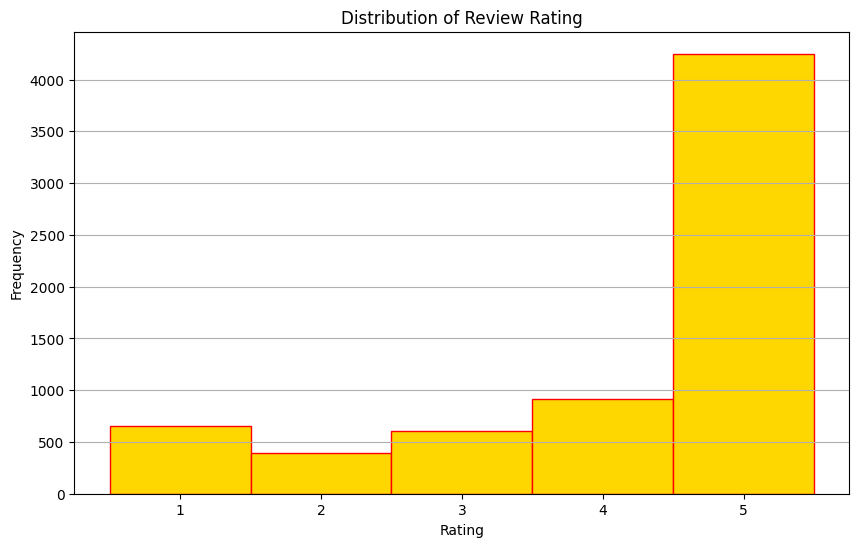

In [8]:
import matplotlib.pyplot as plt

# 데이터 분포도 시각화
plt.figure(figsize=(10, 6))
plt.hist(df['review_rating'], bins=range(1, 7), color='gold', edgecolor='red', align='left')
# 각 축과 그래프 제목 설정
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Review Rating')
plt.xticks(range(1, 6)) # Rating은 1~5의 값으로 존재
plt.grid(axis='y')
# 그래프 출력
plt.show()

In [9]:
nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# VADER 초기화 후 감정 분석 기능 함수 정의
vader_sentiment = SentimentIntensityAnalyzer() # VADER 초기화

def vader_calc(review): # 감성 분석 함수 정의
    return vader_sentiment.polarity_scores(review)["compound"] # 데이터 감성 분석

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\g_keum523\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
# logistic regression 적용을 위한 값 변환 함수 정의
def vader_change_score(sentiment_score): # 이진값으로 감성 분석 결과를 변경
    if sentiment_score >= 0.1: # 값이 0.1 이상이면 긍정, 나머지는 부정으로 처리
        return 1  # 긍정
    else:
        return 0  # 부정

In [11]:
#  감성 분석 도출 및 데이터 프레임에 계산 결과 추가
df["title_score"] = df.review_title.apply(vader_calc).round(2) # 소수점 두자리까지 계산
df["text_score"] = df.review_text.apply(vader_calc).round(2)

In [12]:
df["title_score"] = df.title_score.apply(vader_change_score) #title_score 값 이진화
df["text_score"] = df.text_score.apply(vader_change_score) # text_score 값 이진화

In [13]:
df_review = df[['product_name', 'text_token', 'text_score']] # 필요한 데이터 열만 뽑아 새로운 데이터 프레임 생성
df_review

,product_name,text_token,text_score
0,Klasified Women's Transparent Clear Sneaker Sh...,love looking converse half price unique ive ne...,1
1,Klasified Women's Transparent Clear Sneaker Sh...,shoe cute nd day wearing tongue started rippin...,1
2,Klasified Women's Transparent Clear Sneaker Sh...,good quality,1
3,Klasified Women's Transparent Clear Sneaker Sh...,great,1
4,"GUESS Women's Bradly Gymnastics Shoe, White, 7 UK",ho scelto il modello bianco con rifinitura die...,0
...,...,...,...
6818,"Clarks Vennor Wing, Men’s Low-Top Sneakers, Bl...",schicker schuh läuft sich gut,0
6819,"Clarks Vennor Wing, Men’s Low-Top Sneakers, Bl...",mieux que je ne limaginais très bonne taille b...,0
6820,"Rohde Men's Tivoli-H Mule, 82 Anthracite, 12.5 UK",habe sie al geschenk gekauft und sie sind sehr...,1
6821,"Rohde Men's Tivoli-H Mule, 82 Anthracite, 12.5 UK",trage diese hausschuhe fast zwei monate jeden ...,0


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
# 데이터 지정
y = df['text_score']

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000) # TF-IDF 벡터화
x = vectorizer.fit_transform(df['text_token']) # text_token을 벡터화한 값 저장

In [16]:
# 학습 데이터와 테스트 데이터로 분할 진행
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=22)

In [17]:
model = LogisticRegression()

# 하이퍼파라미터 그리드 설정
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} # 하이퍼파라미터 값을 0.001 ~ 100까지 소수점 단위로 지정

# 그리드 서치를 사용하여 최적 하이퍼파라미터 탐색
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy') # 그리드 서치 정의, 교차 검증을 위한 fold 횟수는 5회로 설정
grid_search.fit(x_train, y_train) # 그리드 서치 진행

# 최적 하이퍼파라미터 값과 테스트 정확도 출력
print("Best parameters:", grid_search.best_params_)
print("Test Accuracy:", grid_search.score(x_test, y_test)) 

Best parameters: {'C': 10}
Test Accuracy: 0.9236977256052825


In [18]:
# 최적 모델을 사용 데이터 학습 진행
model = grid_search.best_estimator_ # 위에서 C:10 하이퍼파라미터 값을 가진 모델을 model에 저장
model.fit(x_train, y_train) # 학습 진행

# 테스트 데이터에 대해 예측
ytrain_pred = model.predict(x_train)
y_pred = model.predict(x_test)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred) # 정확도 계산
print("Accuracy:", accuracy)

# 정밀도 평가
precision = precision_score(y_test, y_pred, average='weighted')  # 정밀도 계산
print("Precision:", precision)

# 재현율 평가
recall = recall_score(y_test, y_pred, average='weighted')  # 재현율 계산
print("Recall:", recall)

# F1 점수 평가
f1 = f1_score(y_test, y_pred, average='weighted')  # F1 점수 계산
print("F1 Score:", f1)

# ROC-AUC 점수 계산
roc_auc = roc_auc_score(y_test, y_pred)  # roc-auc 계산
print("ROC-AUC Score:", roc_auc)

# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)  # 전체 모델 분류 보고서 도출
print("Classification Report:")
print(class_report)

Accuracy: 0.9236977256052825
Precision: 0.9239480534452297
Recall: 0.9236977256052825
F1 Score: 0.9237725347067293
ROC-AUC Score: 0.9232391243260332
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       587
           1       0.94      0.93      0.93       776

    accuracy                           0.92      1363
   macro avg       0.92      0.92      0.92      1363
weighted avg       0.92      0.92      0.92      1363



모델 평가 결과는 다음과 같다.

**<div>1. 정확도 : 0.9236 </div>**

&ensp;&ensp;&ensp;&ensp;전체 예측 중 실제와 같이 예측한 비율

**<div>2. 정밀도 : 0.9239 </div>**

&ensp;&ensp;&ensp;&ensp;모델이 양성으로 예측한 경우 중 실제로 양성인 비율

**<div>3. 재현율 : 0.9236 </div>**

&ensp;&ensp;&ensp;&ensp;실제로 양성인 데이터 중 모델이 양성으로 예측한 비율

**<div>4. F1 점수 : 0.9237 </div>**

&ensp;&ensp;&ensp;&ensp;정밀도와 재현율의 조화 평균

**<div>5. ROC-AUC 점수 : 0.9232 </div>**

&ensp;&ensp;&ensp;&ensp;ROC 곡선 아래의 면적의 값으로, 1에 가까울수록 좋은 성능을 의미
<br></br>



**<h5>Classification Report를 보면 긍정 감성과 부정 감성 모두 원활히 학습되었음을 알 수 있다. 다만 앞서 언급하였듯, 역시 긍정 감성이 부정 감성에 비해 미세하게 잘 학습됐음을 알 수 있다.</h5>**


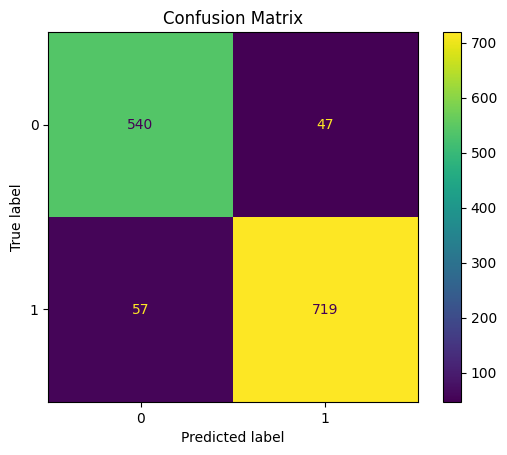

In [20]:
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
display.plot()
plt.title("Confusion Matrix")
plt.show()

혼돈 행렬을 보면, 긍정 응답의 경우 719:57로, 부정 응답의 경우 540:47로 학습 결과가 양호함을 알 수 있다.

C:\Users\g_keum523\AppData\Local\Temp\ipykernel_21304\495367606.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'o--', color="blue", linestyle="--", label=f"ROC curve (area: {roc_auc:.2f})")


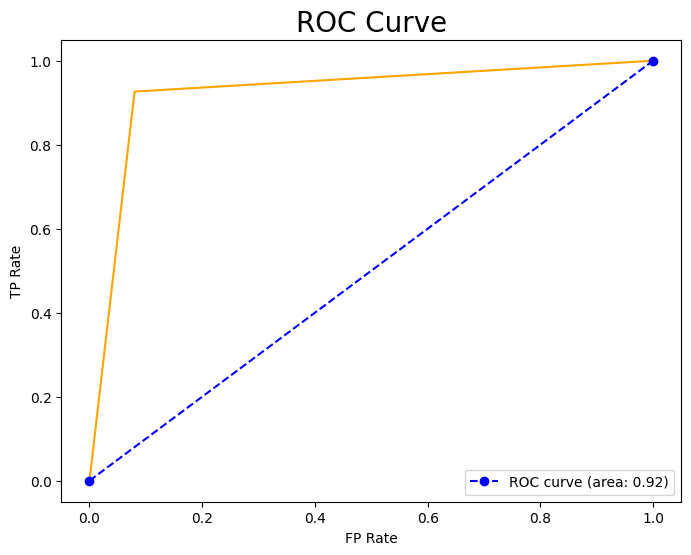

In [21]:
# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# ROC 곡선 아래 면적
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="orange")
plt.plot([0, 1], [0, 1], 'o--', color="blue", linestyle="--", label=f"ROC curve (area: {roc_auc:.2f})") 
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title('ROC Curve', fontsize=20)
plt.legend(loc='lower right')
plt.show()

마지막으로 ROC 곡선을 보자. ROC 곡선은 왼쪽 모서리에 그래프가 가까울수록 학습이 잘 이루어졌다고 여긴다. 또한 ROC-AUC의 값이 1에 가까울수록 학습이 잘 이루어졌다고 본다. 이러한 점을 고려하면 해당 학습 과정이 원활히 이루어졌음을 알 수 있다. 따라서 언더피팅이나 오버피팅의 가능성은 낮다고 볼 수 있겠다.